In [223]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import boto3
import configparser

when we send facebook a meesage like `"how much did I spend on coffee yesterday?"` this is what we get back:

In [120]:
d = {'object': 'page', 'entry': [{'id': '123592025060269', 'time': 1507935214061, 'messaging': [{'sender': {'id': '1718968874810833'}, 'recipient': {'id': '123592025060269'}, 'timestamp': 1507935213825, 'message': {'mid': 'mid.$cAABwaE6TmY1lSTahAVfF_Fbbfii7', 'seq': 23531, 'text': 'how much did I spend on coffee yesterday?', 'nlp': {'entities': {'search_query': [{'suggested': True, 'confidence': 0.93661, 'value': 'coffee', 'type': 'value'}], 'datetime': [{'confidence': 0.96891, 'values': [], 'value': '2017-10-13T00:00:00.000+11:00', 'grain': 'day', 'type': 'value'}], 'intent': [{'confidence': 1, 'value': 'spend'}]}}}}]}]}
d

{'entry': [{'id': '123592025060269',
   'messaging': [{'message': {'mid': 'mid.$cAABwaE6TmY1lSTahAVfF_Fbbfii7',
      'nlp': {'entities': {'datetime': [{'confidence': 0.96891,
          'grain': 'day',
          'type': 'value',
          'value': '2017-10-13T00:00:00.000+11:00',
          'values': []}],
        'intent': [{'confidence': 1, 'value': 'spend'}],
        'search_query': [{'confidence': 0.93661,
          'suggested': True,
          'type': 'value',
          'value': 'coffee'}]}},
      'seq': 23531,
      'text': 'how much did I spend on coffee yesterday?'},
     'recipient': {'id': '123592025060269'},
     'sender': {'id': '1718968874810833'},
     'timestamp': 1507935213825}],
   'time': 1507935214061}],
 'object': 'page'}

In [121]:
d.keys()

dict_keys(['object', 'entry'])

In [122]:
d['entry'][0]['messaging'][0].keys()

dict_keys(['sender', 'recipient', 'timestamp', 'message'])

In [123]:
d['entry'][0]['messaging'][0]['message']['text']

'how much did I spend on coffee yesterday?'

In [124]:
d['entry'][0]['messaging'][0]

{'message': {'mid': 'mid.$cAABwaE6TmY1lSTahAVfF_Fbbfii7',
  'nlp': {'entities': {'datetime': [{'confidence': 0.96891,
      'grain': 'day',
      'type': 'value',
      'value': '2017-10-13T00:00:00.000+11:00',
      'values': []}],
    'intent': [{'confidence': 1, 'value': 'spend'}],
    'search_query': [{'confidence': 0.93661,
      'suggested': True,
      'type': 'value',
      'value': 'coffee'}]}},
  'seq': 23531,
  'text': 'how much did I spend on coffee yesterday?'},
 'recipient': {'id': '123592025060269'},
 'sender': {'id': '1718968874810833'},
 'timestamp': 1507935213825}

In [125]:
msg = d['entry'][0]['messaging'][0]
msg

{'message': {'mid': 'mid.$cAABwaE6TmY1lSTahAVfF_Fbbfii7',
  'nlp': {'entities': {'datetime': [{'confidence': 0.96891,
      'grain': 'day',
      'type': 'value',
      'value': '2017-10-13T00:00:00.000+11:00',
      'values': []}],
    'intent': [{'confidence': 1, 'value': 'spend'}],
    'search_query': [{'confidence': 0.93661,
      'suggested': True,
      'type': 'value',
      'value': 'coffee'}]}},
  'seq': 23531,
  'text': 'how much did I spend on coffee yesterday?'},
 'recipient': {'id': '123592025060269'},
 'sender': {'id': '1718968874810833'},
 'timestamp': 1507935213825}

In [126]:
msg["message"]["nlp"]

{'entities': {'datetime': [{'confidence': 0.96891,
    'grain': 'day',
    'type': 'value',
    'value': '2017-10-13T00:00:00.000+11:00',
    'values': []}],
  'intent': [{'confidence': 1, 'value': 'spend'}],
  'search_query': [{'confidence': 0.93661,
    'suggested': True,
    'type': 'value',
    'value': 'coffee'}]}}

In [127]:
nlp_json = msg["message"]["nlp"]['entities']
print(nlp_json.keys())
nlp_json

dict_keys(['search_query', 'datetime', 'intent'])


{'datetime': [{'confidence': 0.96891,
   'grain': 'day',
   'type': 'value',
   'value': '2017-10-13T00:00:00.000+11:00',
   'values': []}],
 'intent': [{'confidence': 1, 'value': 'spend'}],
 'search_query': [{'confidence': 0.93661,
   'suggested': True,
   'type': 'value',
   'value': 'coffee'}]}

making my own dict of the useful things in the nlp returned from the fb nlp engine:

In [128]:
nlp = {}
for key in nlp_json.keys():
    nlp[key] = nlp_json[key][0]["value"]
    nlp[key+"_confidence"] = nlp_json[key][0]["confidence"]
    if key == "datetime":
        nlp["date_grain"] = nlp_json[key][0]["grain"]
nlp

{'date_grain': 'day',
 'datetime': '2017-10-13T00:00:00.000+11:00',
 'datetime_confidence': 0.96891,
 'intent': 'spend',
 'intent_confidence': 1,
 'search_query': 'coffee',
 'search_query_confidence': 0.93661}

In [129]:
if nlp["intent"] == "spend" and nlp['intent_confidence'] > 0.4:
    if "search_query" in nlp.keys():
        

{'search_query': 'coffee', 'search_query_confidence': 0.93661, 'datetime': '2017-10-13T00:00:00.000+11:00', 'datetime_confidence': 0.96891, 'date_grain': 'day', 'intent': 'spend', 'intent_confidence': 1}


In [185]:
def cost(what, when=None):
    # ignoring the date for now
    if what in data.category.values:
        return -data[data.category.values == what]["amount"].sum()

cost("Amazon")

85.0

In [131]:
data = pd.read_csv("data/pocketbook-export.csv")
data.head()

,date,description,category,amount,notes,tags,bank,accountname,accountnumber
0,01/09/2012,Credit Interest,Bank - Interest,1.95,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497
1,08/09/2012,Parentalleavepay Tp1s4177210293941c,NaN,309.90,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497
2,22/09/2012,Parentalleavepay Tp1s4527210293941c,NaN,1032.00,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497
3,26/09/2012,Parentalleavepay Tp1s4597210293941c,NaN,206.60,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497
4,01/10/2012,Credit Interest,Bank - Interest,3.57,NaN,NaN,COMMONWEALTH_BANK_NET_BANK,Savings,06 2210 1027 9497


In [135]:
data[data["category"] == "Bank - Interest"]["amount"].sum()

11.079999999999993

In [154]:
totals = data.groupby("category").sum().reset_index()
totals.head()

,category,amount
0,Amazon,-85.00
1,Bank - Fees,-1022.29
2,Bank - Interest,11.08
3,Bicycle,-177.00
4,Car - Costs,-1543.01


In [167]:
if "Amazon" in totals.category.values:
    print(totals[totals.category=="Amazon"]["amount"])

0   -85.0
Name: amount, dtype: float64


In [180]:
data[data.category.values == "Amazon"]["amount"].sum()

-85.0

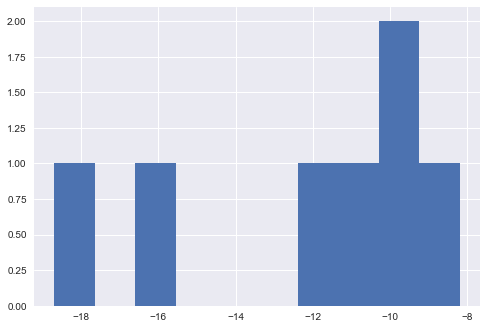

In [187]:
data[data.category.values == "Amazon"]["amount"].hist()

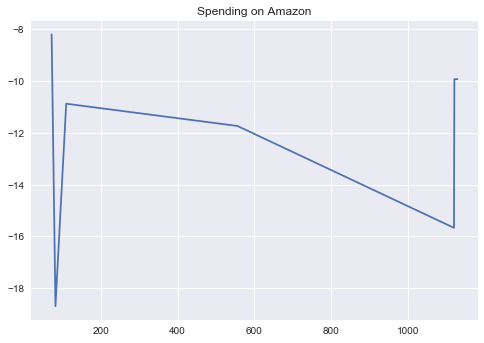

In [197]:
plt.plot(data[data.category.values == "Amazon"]["amount"])
plt.title("Spending on Amazon")
plt.savefig("images/test.png")

In [195]:
data[data.category.values == "Amazon"]["date"]

72      06/07/2014
82      09/07/2014
110     13/07/2014
556     12/10/2014
1120    22/02/2015
1121    22/02/2015
1129    24/02/2015
Name: date, dtype: object

In [205]:
image_name="aaaa"
{"url": "images"+image_name}

{'url': 'imagesaaaa'}

In [206]:
i = {'recipient': {'id': '1718968874810833'}, 'message': {'attachment': {'type': 'image', 'payload': {'url': 'https://5d04f8fe.ngrok.io/static/test.png'}}}}
i

{'message': {'attachment': {'payload': {'url': 'https://5d04f8fe.ngrok.io/static/test.png'},
   'type': 'image'}},
 'recipient': {'id': '1718968874810833'}}

you spent -11.079999999999993 at Bank - Interest


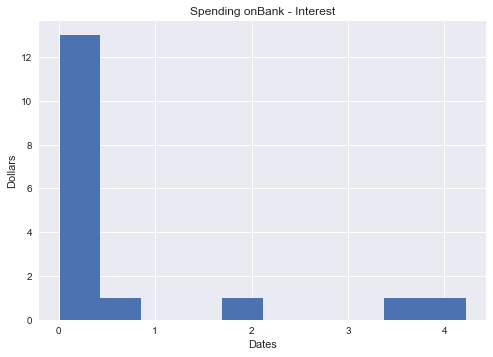

In [218]:
def cost_of(user_id, what, when=None):
    # ignoring the date for now
    if what in data.category.values:
        total_spend = -data[data.category.values == what]["amount"].sum()
        
        # lets tell the user how much was spent on this category
        msg = f"you spent {total_spend} at {what}"
        print(msg)
        #reply(user_id, msg)

        # lets plot something
        plt.hist(data[data.category.values == what]["amount"])
        plt.title("Spending on" + what)
        plt.xlabel("Dates"), plt.ylabel("Dollars")
        plt.savefig("static/test.png")
        plt.show()
        #reply(user_id, image_name="test.png")

    else: # dealing for when the users category isn't found
        msg = f"Can't find {when} in your transactions, pls try something else"
        reply(user_id, msg)
        
cost_of(333, "Bank - Interest")

testing to see if can upload images to s3

In [232]:
# api keys are in config.ini to keep them out of github
config = configparser.ConfigParser()
config.read('config.ini')
try:
    APP_ID = config['facebook']["APP_ID"]
    PAGE_ACCESS_TOKEN = config['facebook']["PAGE_ACCESS_TOKEN"]
    VERIFY_TOKEN = config['facebook']["VERIFY_TOKEN"]
    APP_SECRET = config['facebook']["APP_SECRET"]
    PAGE_ID = config['facebook']["PAGE_ID"]
    aws_access_key_id = config['amazon']['aws_access_key_id']
    aws_secret_access_key = config['amazon']['aws_secret_access_key']

except KeyError:
    print("Missing keys in the config.ini file")

In [260]:
# lower lever way to use s3
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    )

In [335]:
# higher level api
s3 = boto3.resource('s3', 
                    aws_access_key_id=aws_access_key_id, 
                    aws_secret_access_key=aws_secret_access_key)

data = open('static/test.png', 'rb')
s3.Bucket("paisabot").put_object(Key="test123.png", Body=data, ContentType="image/png", ACL="public-read")

s3.Object(bucket_name='paisabot', key='test123.png')

In [336]:
url = "http://paisabot.s3.amazonaws.com/" + image_name
url

'http://paisabot.s3.amazonaws.com/aaaa'